In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from xml2df.xml2df import xml2df
import cv2
from pathlib import Path
import pandas as pd
import os
import torch
from torch.optim import AdamW
from utils import non_max_suppression, create_img_for_plotting

In [2]:
images_path = Path("data/images")
annotations_path = Path("data/annotations")

## EDA

In [3]:
# for i in zip(sorted(images_path.glob("*.png")), sorted(annotations_path.glob("*.xml"))):
#     print(i)
full_dataset_annotations = pd.DataFrame()
for i in sorted(annotations_path.glob("*.xml")):
    df = xml2df(i)
    full_dataset_annotations = full_dataset_annotations.append(df, ignore_index = True)


In [4]:
full_dataset_annotations.loc[:, ['filename', 'size.width', 'size.height']] = full_dataset_annotations[['filename', 'size.width', 'size.height']].ffill()

In [5]:
numeric_columns = ['size.width', 'size.height','object.bndbox.xmin','object.bndbox.ymin','object.bndbox.xmax','object.bndbox.ymax']

In [6]:
full_dataset_annotations[numeric_columns] = full_dataset_annotations[numeric_columns].astype(int)

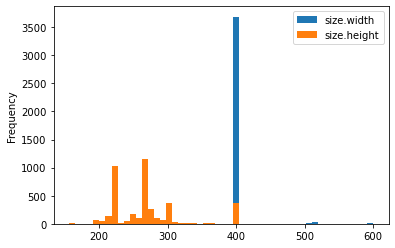

In [7]:
_ = full_dataset_annotations[['size.width', 'size.height']].plot.hist(bins = 50)

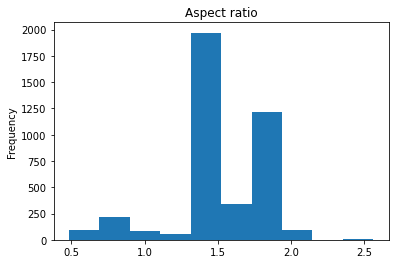

In [8]:
_ = (full_dataset_annotations['size.width']/full_dataset_annotations['size.height']).plot.hist()
_ = plt.title("Aspect ratio")

Text(0.5, 1.0, 'Distribution of labels')

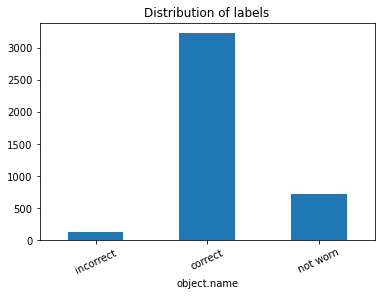

In [9]:
ax = full_dataset_annotations.groupby("object.name").size().plot.bar()
ax.set_xticklabels(["incorrect", "correct", "not worn"])
ax.tick_params(axis = 'x', labelrotation = 25)
plt.title("Distribution of labels")

Text(0.5, 1.0, 'Mean number of objects in an image\nper class')

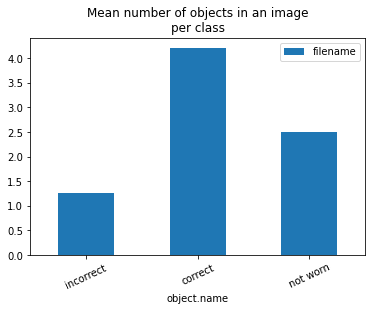

In [10]:
ax = full_dataset_annotations.groupby("object.name").agg({"filename": (lambda x: np.unique(x, return_counts = True)[1].mean())}).plot.bar()
ax.set_xticklabels(["incorrect", "correct", "not worn"])
ax.tick_params(axis = 'x', labelrotation = 25)
plt.title("Mean number of objects in an image\nper class")

Bbox annotation format: PascalVOC: xmin, ymin, xmax, ymax

## Build Dataset

In [11]:
full_dataset_annotations.loc[:, 'VOCbbox'] = full_dataset_annotations[['object.bndbox.xmin',
                                                                       "object.bndbox.ymin",
                                                                       "object.bndbox.xmax",
                                                                       "object.bndbox.ymax"]].apply(lambda x: list(x), axis = 1)

In [12]:
label_encoding = {"with_mask":0, "without_mask":1, "mask_weared_incorrect":2}

In [13]:
inv_encoding = {v:k for k,v in label_encoding.items()}

In [14]:
full_dataset_annotations.loc[:, "encoded_label"] = full_dataset_annotations["object.name"].replace(label_encoding)

In [15]:
dataset = full_dataset_annotations.groupby('filename')\
                .agg({"VOCbbox":list, "object.name": list, "encoded_label": list})\
                .rename(columns = {"object.name": "label"}).reset_index()

In [16]:
dataset.loc[:, 'filename'] = dataset['filename'].apply(lambda x: os.path.join(images_path, x))

In [17]:
incorrect = dataset.label.apply(lambda x: "mask_weared_incorrect" in x)
without = dataset.label.apply(lambda x: "without_mask" in x)

In [18]:
stratify_label = pd.Series(["with_mask"]*len(without), index = dataset.index)
stratify_label[incorrect] = "mask_weared_incorrect" 
stratify_label[(without)&(~incorrect)] = "without_mask"

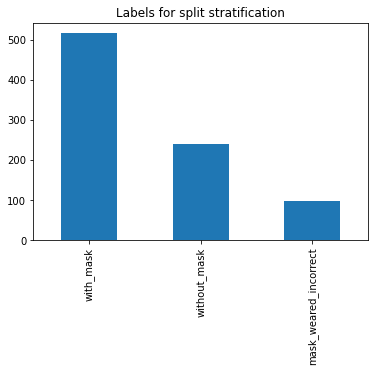

In [19]:
_ = stratify_label.value_counts().plot.bar()
_ = plt.title("Labels for split stratification")

In [20]:
dataset=dataset.drop(columns=['label'])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
dataset_train, dataset_test = train_test_split(dataset, random_state = 42, test_size = 0.2, stratify=stratify_label)

In [23]:
dataset_train.VOCbbox.iloc[0]

[[49, 157, 144, 225], [151, 67, 270, 198]]

## Model training

In [24]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms


In [25]:
from torchvision.transforms import Compose, ToTensor

In [26]:
from utils import draw_basic_bbox

In [27]:
from dataset import FaceMaskVOCDataset

In [28]:
ds = FaceMaskVOCDataset(dataset_train, 224, 224)
ds_test = FaceMaskVOCDataset(dataset_test, 224, 224, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


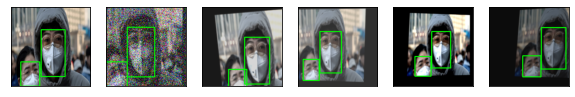

In [29]:
ds.training = False
fig = plt.figure(figsize = (10,5))
ax = fig.subplots(1,6)
img, targets = ds[0]
bboxes = targets['boxes'].numpy().astype(int)
img = img.permute(1,2,0).numpy()
ax[0].imshow(draw_basic_bbox(img, bboxes))
ax[0].get_yaxis().set_visible(False)
ax[0].get_xaxis().set_visible(False)

ds.training = True
for i in range(1,6):
    img, targets = ds[0]
    bboxes = targets['boxes'].numpy().astype(int)
    img = img.permute(1,2,0).numpy()
    ax[i].imshow(draw_basic_bbox(img, bboxes))
    ax[i].get_yaxis().set_visible(False)
    ax[i].get_xaxis().set_visible(False)
#plt.imshow(draw_basic_bbox(i, torch.FloatTensor(bb).numpy().astype(int)))



In [30]:
data_loader_train = torch.utils.data.DataLoader(
    ds, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))) # output: ((images), (targets))

In [31]:
data_loader_test = torch.utils.data.DataLoader(
    ds_test, batch_size=8, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))) # output: ((images), (targets))

# Train

In [32]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from utils import linear_learning_rate_warmup, linear_warmup_factor_wrapper
from tqdm.notebook import tqdm

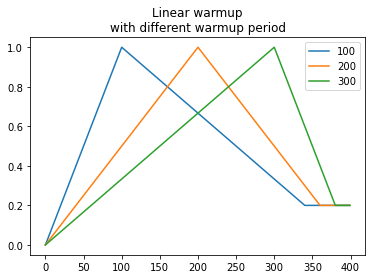

In [33]:
f = linear_warmup_factor_wrapper(100, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='100')
f = linear_warmup_factor_wrapper(200, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='200')
f = linear_warmup_factor_wrapper(300, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='300')
plt.legend()
_ = plt.title("Linear warmup\nwith different warmup period")

In [48]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = 3+1)

In [49]:
model.roi_heads.has_keypoint()

False

In [50]:
# for i, m in model.named_children():
#     print(i)
#     for j,p in m.named_parameters():
#         print(j, p.requires_grad)

In [51]:
from types import MethodType

from custom_forward_functions import forward_rcnn, forward_roi_heads

model.forward = MethodType(forward_rcnn, model)
model.roi_heads.forward = MethodType(forward_roi_heads, model.roi_heads)

In [52]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision


In [53]:
lr = 0.01

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 6
model.to(device)
optimizer = AdamW(model.parameters(), lr = lr)

num_batches = len(data_loader_train)

lr_scheduler = linear_learning_rate_warmup(optimizer,
                                           int(0.3*num_batches*epochs), 
                                           num_batches*epochs,
                                           min_factor = 0.2)
train_losses = []
test_losses = []
mAP = []
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss_train = 0
    epoch_loss_test = 0
    mAP = 0
    pbar = enumerate(data_loader_train)
    print("EPOCH: ", epoch)

    pbar = tqdm(pbar, total=num_batches, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    
    optimizer.zero_grad()
    
    
    for i, (imgs, annotations) in pbar:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict, preds = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        
        #print(losses)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        train_losses.append(losses.item())
        epoch_loss_train += losses.item()
    print('Epoch_loss = ',epoch_loss_train/len(data_loader_train))
    
    pbar = enumerate(data_loader_test)
    print("EPOCH: ", epoch)

    pbar = enumerate(data_loader_test)
    pbar = tqdm(pbar, total=len(data_loader_test), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    
    for i, (imgs, annotations) in pbar:
        mean_AP = MeanAveragePrecision()
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict, preds  = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        
        test_losses.append(losses.item())
        mean_AP.update(preds, annotations)
        mAP+=mean_AP.compute()['map'].item()
        epoch_loss_test += losses.item()
    print('Epoch_loss = ',epoch_loss_test/len(data_loader_test))
    print('Epoch_mAP = ', mAP/len(data_loader_test))

EPOCH:  1
EPOCH:  1


  0%|          | 0/22 [00:00<?, ?it/s]

Proposals [tensor([[ 14.1780, 380.4618, 691.3777, 787.9147],
        [114.2916, 355.9841, 611.2203, 781.0178],
        [  0.0000, 241.6168, 748.6665, 800.0000],
        ...,
        [ 75.6978, 786.4009, 126.3784, 797.4509],
        [508.5310, 223.2728, 524.4806, 259.8376],
        [217.8206, 453.3164, 280.7163, 530.0332]]), tensor([[354.6830, 274.5496, 615.2418, 800.0000],
        [  8.0326, 374.6028, 193.5838, 702.4570],
        [227.2759, 252.3098, 656.5054, 800.0000],
        ...,
        [706.9288,  72.0449, 756.1052,  97.3958],
        [ 64.8575, 648.3418,  86.6652, 697.5242],
        [  0.0000, 650.4422, 100.9431, 800.0000]]), tensor([[2.2786e+02, 1.8005e+02, 4.6323e+02, 8.0000e+02],
        [2.5712e+02, 7.1221e+01, 5.1463e+02, 8.0000e+02],
        [3.2109e-01, 1.8579e+02, 1.2878e+02, 7.4939e+02],
        ...,
        [3.2512e+02, 3.9027e+02, 5.4731e+02, 7.0775e+02],
        [2.1270e+02, 5.2518e+02, 3.5202e+02, 8.0000e+02],
        [6.3773e+01, 7.2424e+01, 3.6343e+02, 3.4759e+02]

Proposals [tensor([[386.7601, 161.5867, 727.0463, 742.1857],
        [ 72.2824, 279.4150, 404.7189, 792.9839],
        [400.3034, 175.5753, 760.4074, 610.5066],
        ...,
        [  0.0000, 366.8846,  11.9004, 481.7798],
        [500.4505, 118.2952, 544.5447, 157.3273],
        [756.9285, 227.1218, 800.0000, 258.9005]]), tensor([[159.3047, 165.2819, 800.0000, 800.0000],
        [242.0535, 296.0049, 800.0000, 793.1682],
        [ 92.3290, 374.2512, 800.0000, 792.1837],
        ...,
        [ 12.5198,  79.8450, 149.9683, 192.1666],
        [201.7503, 465.2529, 420.6037, 586.1410],
        [  0.0000,   0.0000, 136.1797,  92.6370]]), tensor([[142.8349, 119.9268, 395.2519, 713.3011],
        [175.6650, 238.0737, 388.0250, 738.1084],
        [416.5642,  56.8664, 626.0084, 794.7037],
        ...,
        [284.5652, 214.7394, 306.8324, 270.2569],
        [126.0472, 243.6674, 138.4339, 283.8539],
        [271.5317,  50.2601, 542.8588, 339.5856]]), tensor([[200.6483, 381.2298, 790.0364, 793.5

KeyboardInterrupt: 

In [39]:
torch.save(model.state_dict(), "trained_model.ckpt")

# Eval

In [38]:
model = model.eval()

In [39]:
preds = model(imgs)

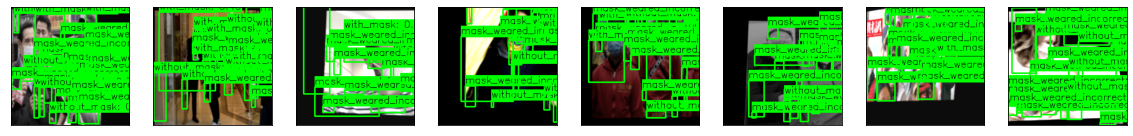

In [41]:
fig = plt.figure(figsize = (20,20))
ax = fig.subplots(1, len(imgs))
for i, (img, pred) in enumerate(zip(imgs, preds)):
    bboxes, labels, scores = non_max_suppression(pred, iou_threshold=0.05, obj_score_thresh=0.2)
    img = (img.permute(1,2,0).numpy()*255).astype(np.int32).copy()
    img = create_img_for_plotting(img, inv_encoding, bboxes, labels, scores)
    ax[i].get_yaxis().set_visible(False)
    ax[i].get_xaxis().set_visible(False)
    ax[i].imshow(img)

In [70]:
#model = fasterrcnn_resnet50_fpn(pretrained=True)

## Eval

In [58]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [59]:
def non_max_suppression(preds: dict, iou_threshold: float = 0.25, obj_score_thresh = 0.0):
    bboxes = preds['boxes']
    labels = preds['labels']
    scores = preds['scores']
    objectness_mask = scores>obj_score_thresh
    keep_indices = nms(bboxes[objectness_mask], scores[objectness_mask], iou_threshold)
    
    return bboxes[keep_indices], labels[keep_indices], scores[keep_indices]

In [60]:
model.rpn.anchor_generator.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'sizes': ((32,), (64,), (128,), (256,), (512,)),
 'aspect_ratios': ((0.5, 1.0, 2.0),
  (0.5, 1.0, 2.0),
  (0.5, 1.0, 2.0),
  (0.5, 1.0, 2.0),
  (0.5, 1.0, 2.0)),
 'cell_anchors': [tensor([[-23., -11.,  23.,  11.],
          [-16., -16.,  16.,  16.],
          [-11., -23.,  11.,  23.]]),
  tensor([[-45., -23.,  45.,  23.],
          [-32., -32.,  32.,  32.],
          [-23., -45.,  23.,  45.]]),
  tensor([[-91., -45.,  91.,  45.],
          [-64., -64.,  64.,  64.],
          [-45., -91.,  45.,  91.]]),
  tensor([[-181.,  -91.,  181.,   91.],
          [-128., -128.,  128.,  128.],
          [ -91., -181.,   91.,  181.]]),


In [61]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [62]:
def forward(self,):
    print(self)

In [68]:
model.forward(imgs)

CLASS LOGITS:  torch.Size([8000, 6])
PRED SCORES LIST:  8 torch.Size([1000, 6])
SCORES:  torch.Size([1000, 5, 4]) torch.Size([1000, 5]) tensor([[0.2225, 0.1611, 0.2307, 0.1529, 0.1372],
        [0.1244, 0.1828, 0.2074, 0.1657, 0.2564],
        [0.2064, 0.1451, 0.2084, 0.1831, 0.1411],
        ...,
        [0.1366, 0.1864, 0.2000, 0.1428, 0.2099],
        [0.1330, 0.2654, 0.2390, 0.1458, 0.1217],
        [0.0927, 0.2365, 0.2656, 0.1508, 0.0982]], grad_fn=<SliceBackward0>)
AFTER FLATTENING:  torch.Size([5000]) torch.Size([5000, 4]) tensor([0.2225, 0.1611, 0.2307,  ..., 0.2656, 0.1508, 0.0982],
       grad_fn=<UnsafeViewBackward0>)
AFTER INDEXING:  torch.Size([5000]) tensor([0.2225, 0.1611, 0.2307,  ..., 0.2656, 0.1508, 0.0982],
       grad_fn=<IndexBackward0>)
AFTER KEEPING:  torch.Size([5000]) tensor([0.2225, 0.1611, 0.2307,  ..., 0.2656, 0.1508, 0.0982],
       grad_fn=<IndexBackward0>)
AFTER NMS:  torch.Size([100]) tensor([0.3419, 0.3245, 0.3168, 0.3166, 0.3130, 0.3106, 0.3105, 0.3086

AFTER KEEPING:  torch.Size([5000]) tensor([0.1882, 0.2243, 0.2022,  ..., 0.1261, 0.1946, 0.1974],
       grad_fn=<IndexBackward0>)
AFTER NMS:  torch.Size([100]) tensor([0.3162, 0.3074, 0.2986, 0.2982, 0.2973, 0.2951, 0.2946, 0.2924, 0.2901,
        0.2900, 0.2870, 0.2863, 0.2861, 0.2858, 0.2854, 0.2829, 0.2825, 0.2816,
        0.2814, 0.2813, 0.2810, 0.2809, 0.2803, 0.2761, 0.2752, 0.2752, 0.2745,
        0.2739, 0.2738, 0.2737, 0.2728, 0.2722, 0.2717, 0.2687, 0.2679, 0.2676,
        0.2653, 0.2652, 0.2652, 0.2649, 0.2646, 0.2644, 0.2633, 0.2629, 0.2622,
        0.2619, 0.2617, 0.2617, 0.2594, 0.2592, 0.2592, 0.2589, 0.2586, 0.2580,
        0.2579, 0.2575, 0.2569, 0.2563, 0.2563, 0.2561, 0.2557, 0.2551, 0.2551,
        0.2547, 0.2544, 0.2543, 0.2543, 0.2539, 0.2533, 0.2532, 0.2528, 0.2527,
        0.2526, 0.2519, 0.2517, 0.2517, 0.2516, 0.2515, 0.2512, 0.2510, 0.2508,
        0.2507, 0.2507, 0.2500, 0.2500, 0.2499, 0.2495, 0.2492, 0.2488, 0.2487,
        0.2482, 0.2481, 0.2478, 0.2473,

[{'boxes': tensor([[1.4535e+02, 1.6346e+02, 1.9526e+02, 1.9279e+02],
          [1.3118e+02, 1.4807e+02, 1.6553e+02, 1.9987e+02],
          [1.4183e+02, 1.3755e+02, 1.7259e+02, 1.8734e+02],
          [1.1531e+02, 1.2078e+02, 1.8140e+02, 2.1045e+02],
          [8.2189e+01, 9.8953e+01, 1.3462e+02, 1.2756e+02],
          [8.1462e+01, 2.5099e+01, 1.4536e+02, 1.4324e+02],
          [6.6296e+01, 9.4132e+01, 1.8070e+02, 1.5737e+02],
          [7.1340e+00, 2.8163e+00, 1.8040e+02, 2.8978e+01],
          [5.9229e+01, 1.1149e+02, 1.9537e+02, 2.1469e+02],
          [8.7105e+01, 7.7346e+01, 1.5901e+02, 1.9519e+02],
          [8.6220e+01, 1.1154e+02, 1.3706e+02, 1.3937e+02],
          [2.1164e+02, 1.9102e+02, 2.2142e+02, 1.9950e+02],
          [9.2474e+01, 1.9803e+01, 2.0192e+02, 1.0318e+02],
          [1.2948e+02, 8.9301e+01, 1.9759e+02, 2.1981e+02],
          [1.4321e+02, 1.4760e+02, 1.7869e+02, 1.7558e+02],
          [1.0380e+02, 1.9597e+02, 1.9954e+02, 2.1696e+02],
          [6.6838e+01, 6.4701e+

In [48]:
model.roi_heads.score_thresh

0.05

In [55]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

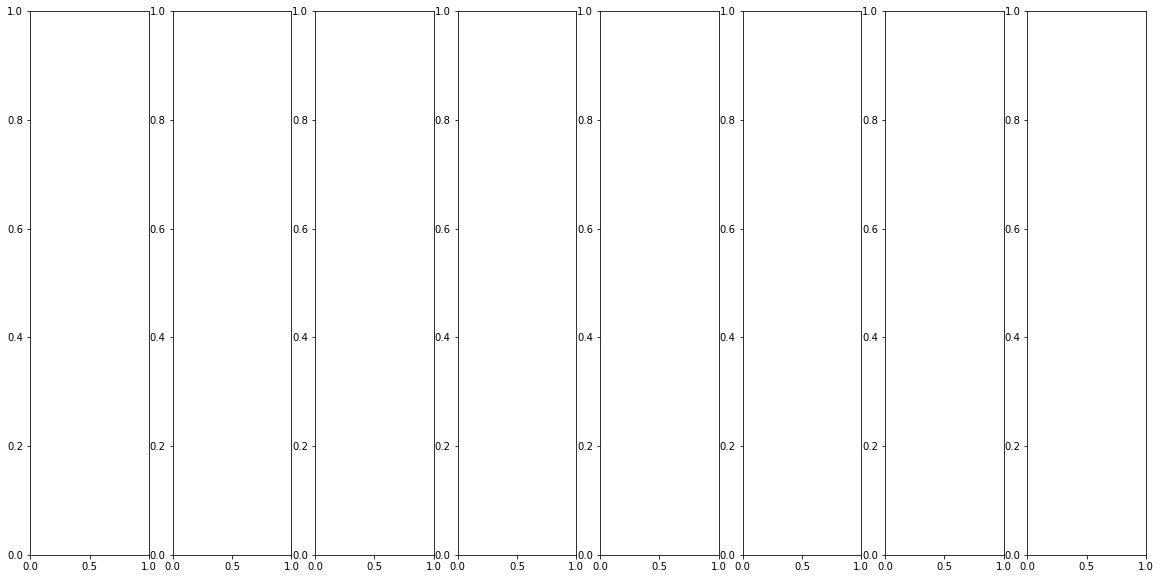

In [50]:
preds[0]

{'boxes': tensor([[109.1955,  28.5178, 216.1039, 121.0470],
         [ 29.7273, 111.3325, 221.4623, 220.4768],
         [111.9215, 121.7713, 224.0000, 210.6316],
         [ 70.6838, 173.8722, 219.5196, 217.9938],
         [ 45.9794, 123.2416, 100.8057, 219.9861],
         [104.8602,  16.6202, 162.5326, 147.8559],
         [  4.2500, 174.2982, 149.4872, 219.4277],
         [111.2238, 126.0293, 121.9861, 139.0635],
         [126.3272, 137.7188, 181.7556, 211.8089],
         [105.9516, 116.4095, 118.8329, 138.6142],
         [118.6241,  13.1983, 224.0000,  72.0835],
         [136.8347,  10.1489, 224.0000, 159.5311],
         [ 88.1928,   2.4794, 198.2349, 192.2030],
         [  0.0000, 198.0053, 153.6172, 224.0000],
         [  0.0000,  88.1451, 166.2716, 212.3879],
         [165.8792, 135.1163, 222.0540, 215.9253],
         [ 71.2233, 126.1327,  79.0489, 138.6890],
         [ 85.5194, 199.2032,  95.5878, 209.2007],
         [143.3443, 126.7712, 156.6633, 156.3113],
         [144.7526, 13